## Overview 
1. Data analysis of given data
2. Check Covariance
3. ??

# 1.Data analysis of given data
The goal of this analysis is to visulaize and clean if neccessay ... 

In [1]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

# import data
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# weather data
datasets = {
    "DWD Demand": dwd_demand,
    "DWD Hornsea": dwd_hornsea,
    "DWD PES10": dwd_pes10,
    "NCEP Demand": ncep_demand,
    "NCEP Hornsea": ncep_hornsea,
    "NCEP PES10": ncep_pes10
}

# demand data
demand_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Explore data, look at variables, dimensions ect.

In [ ]:
# Show variables, dimensions, shapes, and units of a dataset 
def describe_nc_dataset(dataset, dataset_name):
    print(f"\nOverview of {dataset_name}")   
    for var in dataset.variables.values():
        name = var.name 
        dims = var.dimensions
        shape = var.shape
        units = var.units if 'units' in var.ncattrs() else 'N/A'
        print(f"{name}: {dims} {shape} {units}")

for name, ds in datasets.items():
    describe_nc_dataset(ds, name)

print("n\Overview of Demand Data")
print(demand_data.info())
print(demand_data.head())

# Check Missing Values

In [ ]:
def check_missing_values(dataset, dataset_name):
    print(f"\nChecking missing values for: {dataset_name}")
    has_missing = False
    
    for var_name in dataset.variables:
        var = dataset.variables[var_name]
        missing_count = pd.isnull(var[:]).sum()
        
        if missing_count > 0:
            if not has_missing:
                print("Variables with missing values:")
                has_missing = True
            print(f"- {var_name}: {missing_count} missing values")
    
    if not has_missing:
        print("No missing values found in any variable")
    
for name, dataset in datasets.items():
    check_missing_values(dataset, name)

print("\nChecking missing values for Demand Data")
print(demand_data.isnull().sum())

# Check Time and Frequency

In [ ]:
def inspect_time(dataset, dataset_name):
    print(f"\nStart and Stop Times for {dataset_name}:")
    time_var = dataset.variables["ref_datetime"]
    print(f"Units: {time_var.units}")
    print(f"Start: {nc.num2date(time_var[0], time_var.units)}")
    print(f"End: {nc.num2date(time_var[-1], time_var.units)}")

def inspect_frequency(dataset, dataset_name):
    """Compact frequency analysis printer"""
    print(f"\nTime Measurement Frequencies for {dataset_name}:")
    diffs = pd.Series(dataset.variables["ref_datetime"][:]).diff().dropna()
    
    # Print frequency table
    for interval, count in diffs.value_counts().sort_index().items():
        print(f"{interval}: {count} occurrences")
    
    # Print quick stats
    print(f"\nTotal measurements: {len(diffs)+1}")
    print(f"Unique intervals: {diffs.nunique()}")

for name, dataset in datasets.items():
    inspect_time(dataset, name)
    inspect_frequency(dataset, name)

# Load the CSV file (replace with your actual file name)
df =  pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Convert "dtm" to datetime (ISO 8601, with UTC timezone)
df["dtm"] = pd.to_datetime(df["dtm"], utc=True)

# Sort just in case
df = df.sort_values("dtm")

# Calculate time deltas in hours
time_diffs = df["dtm"].diff().dropna().dt.total_seconds() / 3600

# Frequency summary
interval_counts = time_diffs.value_counts().sort_index()

# Display start and end times
start_time = df["dtm"].iloc[0]
end_time = df["dtm"].iloc[-1]

print(f"Start time: {start_time}")
print(f"End time:   {end_time}\n")

# Display time interval frequencies
for interval, count in interval_counts.items():
    print(f"{interval:.1f}: {int(count)} occurrences")

print(f"\nTotal measurements: {len(df)}")
print(f"Unique intervals: {interval_counts.count()}")

# Visualize Data

In [ ]:
from datetime import datetime

# Configuration
point_idx = 6  # Which location to plot (0-6)
variables = ['RelativeHumidity', 'Temperature', 'WindSpeed', 'TotalPrecipitation']
units = ['%', '°C', 'm/s', 'mm']

# Create figure
plt.figure(figsize=(15, 10))

# Convert reference times to datetime
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# Plot each variable
for i, (var, unit) in enumerate(zip(variables, units), 1):
    # Get and aggregate data
    data = dwd_demand.variables[var][:, :, point_idx]  # [ref, valid, point]
    mean_values = np.nanmean(data, axis=1)  # Handles any NaN values
    
    # Create subplot
    plt.subplot(2, 2, i)
    plt.plot(ref_times_datetime, mean_values, 'b-', alpha=0.7)
    plt.title(f'{var} at Point {point_idx}')
    plt.ylabel(unit)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
points = dwd_demand.variables['point'][:] # 0 1 2 3 4 5 6 
lats = dwd_demand.variables['latitude'][:]
lons = dwd_demand.variables['longitude'][:]

# Plot latitide and longitude
plt.figure(figsize=(6, 6))
plt.plot(lats, lons, 'o')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()


In [ ]:
print("start")

# extract powers
dtm_demand = demand_data["dtm"]
solar_MW_05h = demand_data["Solar_MW"]
wind_MW_05h = demand_data["Wind_MW"]
production_MW_05h = solar_MW_05h + wind_MW_05h

# look at first missing values
#first_nan_index = production_MW_05h.isna().idxmax()
#print(first_nan_index)
# Solar -> 12485
# Wind -> 20208
# Both -> 12485 

#dtm_demand.iloc[12485]
# 2021-06-07T02:30:00Z
# closest index 12480 -> 2021-06-07T00:00:00

# Readjust powers
solar_MW_6h = solar_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
wind_MW_05h = wind_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
production_MW_05h = production_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
# len ->12480/12 = 1040

# find index for weather data
#ref_times = nc.num2date(dwd_hornsea.variables['ref_datetime'][:],
#                       dwd_hornsea.variables['ref_datetime'].units)
#ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]
#print(ref_times_datetime[1034]) -> index 1034 (dwd_demand, dwd_hornsea, dwd_pes10)

point_idx = 1
weather_idx = 1040
# Fuck it use 1039 to get the vectors the same lengt
dwd_demand_RelativeHumidity = dwd_demand.variables["RelativeHumidity"][0:weather_idx, :, point_idx]
dwd_demand_Temperature = dwd_demand.variables["Temperature"][0:weather_idx, :, point_idx]
dwd_demand_TotalPrecipitation = dwd_demand.variables["TotalPrecipitation"][0:weather_idx, :, point_idx]
dwd_demand_WindDirection = dwd_demand.variables["WindDirection"][0:weather_idx, :, point_idx]
dwd_demand_WindSpeed = dwd_demand.variables["WindSpeed"][0:weather_idx, :, point_idx]

print(dwd_demand_WindSpeed.shape)
# dwd_hornsea 
dwd_pes10_CloudCover = dwd_pes10.variables["CloudCover"][0:weather_idx, :, point_idx]
dwd_pes10_SolarDownwardRadiation = dwd_pes10.variables["SolarDownwardRadiation"][0:weather_idx, :, point_idx]
dwd_pes10_Temperature = dwd_pes10.variables["Temperature"][0:weather_idx, :, point_idx]

# Step 1: Average weather data over the second axis (valid_datetime)
def avg_over_valid_dim(var):
    return var.mean(axis=1)

# Step 2: Create DataFrame
df_cov = pd.DataFrame({
    "Solar_MW": solar_MW_6h[:1040],
    "Wind_MW": wind_MW_05h[:1040],
    "Total_Production": production_MW_05h[:1040],
    "RelHumidity": avg_over_valid_dim(dwd_demand_RelativeHumidity),
    "Temp_demand": avg_over_valid_dim(dwd_demand_Temperature),
    "Precip": avg_over_valid_dim(dwd_demand_TotalPrecipitation),
    "WindDir": avg_over_valid_dim(dwd_demand_WindDirection),
    "WindSpeed": avg_over_valid_dim(dwd_demand_WindSpeed),
    "CloudCover": avg_over_valid_dim(dwd_pes10_CloudCover),
    "SolarRad": avg_over_valid_dim(dwd_pes10_SolarDownwardRadiation),
    "Temp_PES10": avg_over_valid_dim(dwd_pes10_Temperature)
})

# Step 4: Compute and visualize the covariance matrix
cov_matrix = df_cov.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix of Power Production and Weather Features")
plt.tight_layout()
plt.show()

# Preprocessing Data for Random Forest

We don't need to care about oulier data, this means we don't need to take mean or log to the data to make it more even.
To prefrocess the data we will do some data cleaning this entails fix missing values, fitt the data together so their on the same time-axis to the production time half hour resolution.   


Regarding splitting of data according to Xaviaer we could split the data at the large time gap, after the gap data will be used for training, before data will be slpit 90% for training and the last 10% for validation. Where crossvalidation will be preformed.


Other recomendations:
1. Temporal interpolation (data repair)
2. OneHotEncoder (dummy creation if needed)
3. Rekomended to use around 500 trees


In [ ]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# import data

# Weather data 
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

# Functions
def extract_variable_data(var, idx, ref_times, e_dtm):
    """
    Inputs: NC variable "var", point index "idx", referance time for variable "ref_t"
            and dtm for energy data "e_dtm"
    
    Fills in the referance times in with values from valid time (eavenly spaced),
    then use temporal interpolation to generate x2

    Returns x2 interpolated values for variable allong e_dtm axis
    """
    ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

    # alloc mem 
    n_tot = (var.shape[0])*(var.shape[1])
    values = np.empty(n_tot, dtype = "float32")
    times = np.empty(n_tot, dtype = "datetime64[ns]")

    count  = 0

    for i in range(var.shape[0]):
        # print(str(i)) if you want to se progress but slow it down 
        if i == var.shape[0]-1:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_dt_start + timedelta(hours=6)
        else:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_times_datetime[i + 1]	

        start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
        end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

        time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

        time_steps = time_steps_ns.astype('datetime64[ns]')

        # for every valid time in referance time
        for j in range(var.shape[1]):
            if var[i, j, idx] is np.ma.masked:
                values[count] = np.nan
                times[count] = time_steps[j]
                count += 1

            else: 
                values[count] = np.mean(var[i,j,idx])
                times[count] = time_steps[j]
                count += 1

    t1 = pd.to_datetime(times, utc=True)
    t2 = pd.to_datetime(e_dtm, utc=True)

    combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

    x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

    x1_reindexed = x1.reindex(combined_index)

    assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

    x1_interpolated = x1_reindexed.interpolate(method='time')

    x2 = x1_interpolated.loc[t2]

    return x2

    
# 1. Parse variables
dwd_demand_RelativeHumidity = dwd_demand["RelativeHumidity"]
dwd_demand_Temperature = dwd_demand["Temperature"]
dwd_demand_TotalPrecipitation = dwd_demand["TotalPrecipitation"]
dwd_demand_WindDirection = dwd_demand["WindDirection"]
dwd_demand_WindSpeed = dwd_demand["WindSpeed"]

dwd_hornsea_RelativeHumidity = dwd_hornsea["RelativeHumidity"]
dwd_hornsea_Temperature = dwd_hornsea["Temperature"]
dwd_hornsea_WindDirection = dwd_hornsea["WindDirection"]
dwd_hornsea_WindDirection100 = dwd_hornsea["WindDirection:100"]
dwd_hornsea_WindSpeed = dwd_hornsea["WindSpeed"]
dwd_hornsea_WindSpeed100 = dwd_hornsea["WindSpeed:100"]

dwd_pes10_CloudCover = dwd_pes10["CloudCover"]
dwd_pes10_SolarDownwardRadiation = dwd_pes10["SolarDownwardRadiation"]
dwd_pes10_Temperature = dwd_pes10["Temperature"]

ncep_demand_RelativeHumidity = ncep_demand["RelativeHumidity"]
ncep_demand_Temperature = ncep_demand["Temperature"]
ncep_demand_TotalPrecipitation = ncep_demand["TotalPrecipitation"]
ncep_demand_WindDirection = ncep_demand["WindDirection"]
ncep_demand_WindSpeed = ncep_demand["WindSpeed"]

ncep_hornsea_RelativeHumidity = ncep_hornsea["RelativeHumidity"]
ncep_hornsea_Temperature = ncep_hornsea["Temperature"]
ncep_hornsea_WindDirection = ncep_hornsea["WindDirection"]
ncep_hornsea_WindDirection100 = ncep_hornsea["WindDirection:100"]
ncep_hornsea_WindSpeed = ncep_hornsea["WindSpeed"]
ncep_hornsea_WindSpeed100 = ncep_hornsea["WindSpeed:100"]

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)

# Now comes the shit of handeling the weather data


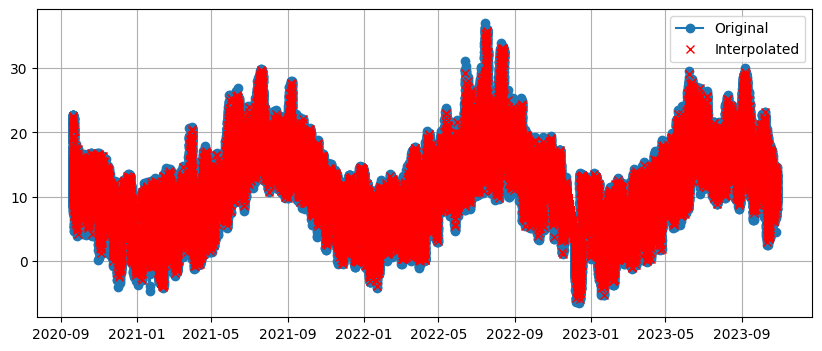

In [ ]:
# Test block for function

# Inputs 
idx = 1 
var = dwd_demand_Temperature
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# alloc mem 
n_tot = (var.shape[0])*(var.shape[1])
values = np.empty(n_tot, dtype = "float32")
times = np.empty(n_tot, dtype = "datetime64[ns]")

count  = 0

# for every referance time
for i in range(var.shape[0]):
    # print(str(i)) if you want to se progress but slow it down 
    if i == var.shape[0]-1:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_dt_start + timedelta(hours=6)
    else:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_times_datetime[i + 1]	

    # Convert to datetime64[ns] explicitly
    start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
    end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

    # Generate linear space in nanoseconds
    time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

    # Convert back to datetime64[ns]
    time_steps = time_steps_ns.astype('datetime64[ns]')

    # for every valid time in referance time
    for j in range(var.shape[1]):
        if var[i, j, idx] is np.ma.masked:
            values[count] = np.nan
            times[count] = time_steps[j]
            count += 1

        else: 
            values[count] = np.mean(var[i,j,idx])
            times[count] = time_steps[j]
            count += 1

t1 = pd.to_datetime(times, utc=True)
t2 = pd.to_datetime(energy_data_dtm, utc=True)

# Combine and sort unique timestamps
combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

# Create the Series with t1
x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

# Reindex to combined time axis
x1_reindexed = x1.reindex(combined_index)

# Check to make sure it's still a DatetimeIndex
assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

# Interpolate
x1_interpolated = x1_reindexed.interpolate(method='time')

# Extract the values at your target timestamps
x2 = x1_interpolated.loc[t2]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(x1.index, x1.values, 'o-', label='Original')
plt.plot(x2.index, x2.values, 'xr', label='Interpolated')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)

result = extract_variable_data(var = dwd_demand_Temperature,
    idx = 1,
    ref_times = test,
    e_dtm = energy_data_dtm)



# This is great and all I've done is enter my name, Thillho 
## ~ Milhouse Mussolini Van Houten

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
#import tensorflow as tf 
#import keras
import matplotlib.pyplot as plt

ds = xr.open_dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
#ds

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)


In [6]:
ds

<xarray.Dataset> Size: 70MB
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 56B ...
    longitude           (point) float64 56B ...
  * point               (point) int64 56B 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 36kB 2020-09-20 ... 202...
  * valid_datetime      (valid_datetime) int64 744B 0 1 2 3 ... 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 12MB ...
    Temperature         (ref_datetime, valid_datetime, point) float32 12MB ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 23MB ...
    WindDirection       (ref_datetime, valid_datetime, point) float32 12MB ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 12MB ...

In [ ]:
    point_idx = 1
    var = ds["Temperature"][:, :, point_idx].values  # shape: (ref_datetime, valid_datetime)
    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values       # e.g., [0, 1, ..., 120]
    
    all_datetimes = []
    all_values = []

    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]

            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    # Make sure energy timestamps are a proper DatetimeIndex
    energy_data_dtm = pd.to_datetime(energy_data_dtm)
    if isinstance(energy_data_dtm, pd.Series):
        energy_data_dtm = energy_data_dtm.values  # remove name if present
    energy_timestamps = pd.DatetimeIndex(energy_data_dtm).tz_localize(None)

    # Create the Series (already using DatetimeIndex)
    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)

    # Remove duplicates by averaging
    ts = ts.groupby(ts.index).mean()

    # Combine and reindex
    combined_index = ts.index.union(energy_timestamps)
    combined_index = pd.DatetimeIndex(combined_index).sort_values()

    # Now safe to interpolate
    ts_reindexed = ts.reindex(combined_index)
    ts_interpolated = ts_reindexed.interpolate(method='time')

    # Final selection at target timestamps
    ts_final = ts_interpolated.loc[energy_timestamps]



In [14]:
print(ts_final)

2020-09-20 00:00:00    83.608330
2020-09-20 00:30:00    84.916176
2020-09-20 01:00:00    86.224022
2020-09-20 01:30:00    87.004837
2020-09-20 02:00:00    87.785645
                         ...    
2023-10-27 21:30:00    90.851379
2023-10-27 22:00:00    91.186562
2023-10-27 22:30:00    90.877731
2023-10-27 23:00:00    90.568901
2023-10-27 23:30:00    90.350861
Length: 54384, dtype: float32
